# Python Group
## Lab Two: Exploring Image Data
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

# TODO

### Citation & Acknowledgement
The Hotels Reservation dataset is liscenced under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

## 2. Data Preperation

In [12]:
# Handle all imports for notebook

# Generic list pulled from last project, modify as desired
import pandas as pd
from pandas import ( DataFrame, Series )
import numpy as np
from numpy import ndarray
import os
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import random
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

In [13]:
df: DataFrame = pd.read_csv("metadata.csv")

In [14]:
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDs, which can be safely removed

In [15]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
(251, 201, 3)     80
(217, 232, 3)     53
(168, 300, 3)     52
(221, 228, 3)     51
(198, 150, 3)     45
(252, 200, 3)     44
(417, 428, 3)     43
(222, 227, 3)     40
(201, 173, 3)     38
(244, 206, 3)     38
(442, 442, 3)     34
(192, 192, 3)     32
(250, 201, 3)     31
(231, 218, 3)     31
(234, 215, 3)     28
Name: shape, dtype: int64


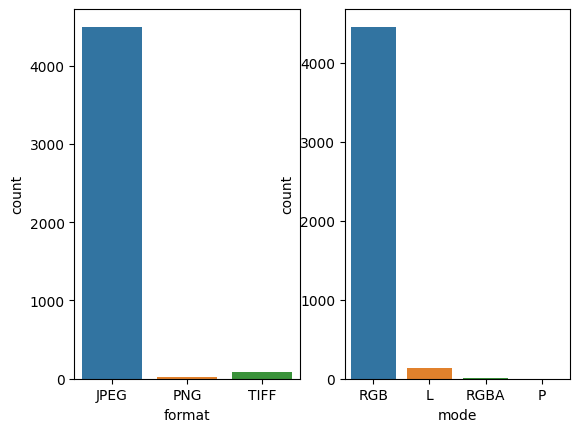

In [16]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=ax[0])
sns.countplot(x="mode", data=df, ax=ax[1])
print("Resolutions by count:\n", df["shape"].value_counts()[0:20])
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=ax[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.
Resolutions will also be restricted to the largest square images in the top 20 most frequent resolutions, with all images to be downscaled to the smallest image to avoid losing data in trying to upscale (shown to be worse than downscaling by [this article](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89).

In [17]:
# First we identify undesirable images
# TODO: convert RGBA to RGB?
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB") |
                 ((df["shape"] != "(630, 630, 3)")
                  & (df["shape"] != "(512, 512, 3)")
                  & (df["shape"] != "(442, 442, 3)")
                  & (df["shape"] != "(256, 256, 3)")
                  & (df["shape"] != "(236, 236, 3)")
                  & (df["shape"] != "(225, 225, 3)")
                  & (df["shape"] != "(192, 192, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [18]:
# Then we remove images we don't want to convert or otherwise process
# We could import the images first and then delete from the numpy arrays to preserve the github dataset, but that's a lot of wasted time & space.
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [19]:
# Confirm we still have more than 1000 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1548 non-null   object
 1   class   1548 non-null   object
 2   format  1548 non-null   object
 3   mode    1548 non-null   object
 4   shape   1548 non-null   object
dtypes: object(5)
memory usage: 72.6+ KB


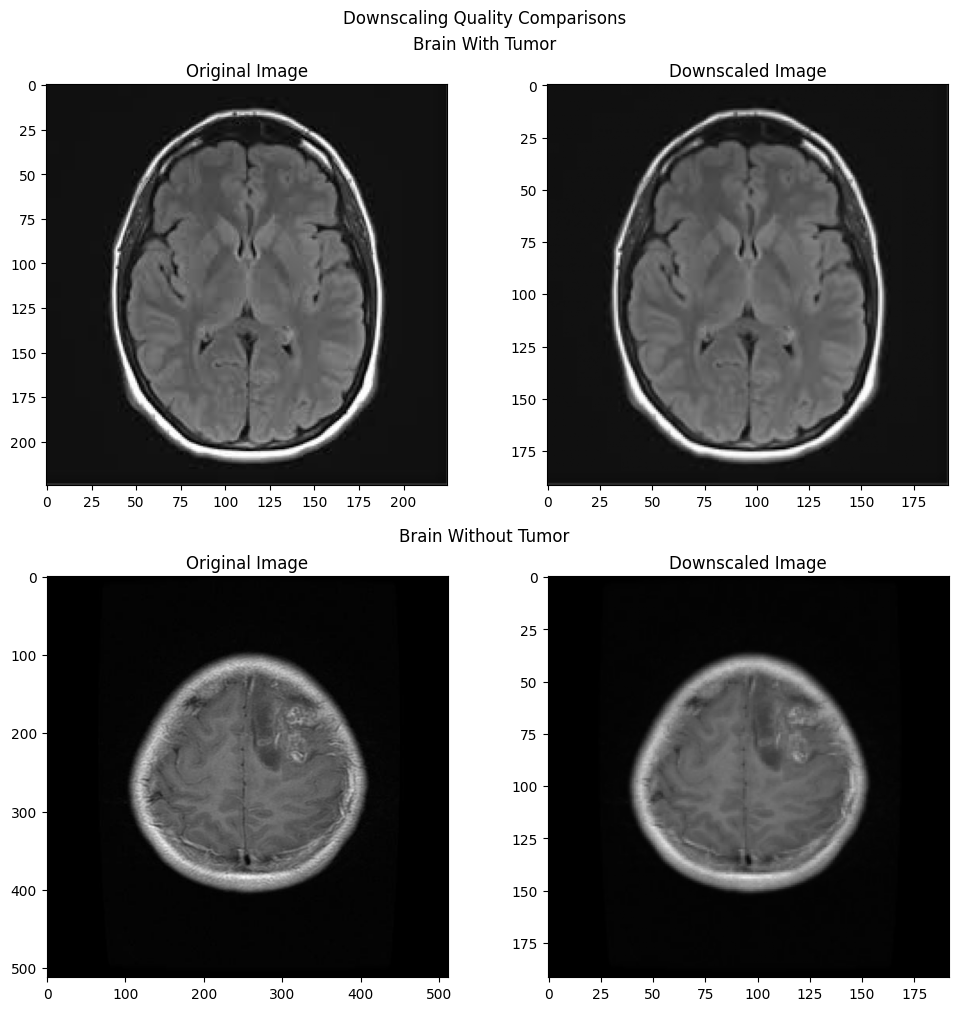

In [20]:
# Now import each image as a numpy array & do the final conversion of their resolutions
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225)
cancer_images = []
healthy_images = []
original_images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in original_images:
    if "Not" in image:
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))

images = []
for image_set in (cancer_images, healthy_images): 
    for image in image_set:
        # Apply the resizing non-uniformly since evidently it affects images
        # even if they're the the same size as the target resolution.
        # Difference with Lienar PCA was:
        #   Applied to every image:
        #     233 components with λ > 1 for 92% explanation
        #   Applied to mis-sized images:
        #     256 components with λ > 1 for 99% explanation
        
        #images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        if len(image) != 192:
            images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        else:
            images.append(image.flatten())
images = np.array(images)

fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle("Downscaling Quality Comparisons")
subfigs = fig.subfigures(2, 1)
ax_cancer = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Brain With Tumor")
ax_cancer[0].imshow(cancer_images[0], cmap='gray')
ax_cancer[0].set_title("Original Image")
ax_cancer[1].imshow(images[0].reshape(192, 192, 3), cmap='gray')
ax_cancer[1].set_title("Downscaled Image")
ax_healthy = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Brain Without Tumor")
ax_healthy[0].imshow(healthy_images[0], cmap='gray')
ax_healthy[0].set_title("Original Image")
ax_healthy[1].imshow(images[len(cancer_images)].reshape(192, 192, 3), cmap='gray')
ax_healthy[1].set_title("Downscaled Image")
plt.show()

In [21]:
# Further preprocessing?

## 3. Data Reduction

<b>Once all of the methods are in we could give a short overview of the pipeline we're looking to assemble here</b>

### 3.1 PCA Preperations
Typically, we would need to do some extra preprocessing of our data to ensure that everything it set within the same range of values, which PCA is highly sensitive to. However, since we have already bound all of our images to the same color mode (RGB), we know that every pixel will be, essentially, a triplet of uint8 repersentations for color between 0 & 255, which will work perfectly well with PCA.

With this taken care of and our data already flattened into rows of samples (images) with columns of features (pixels), our data is ready is be fit to a set of PCAs: both linear and randomized will be used and comparisons drawn between their effectiveness.

### 3.2 Linear PCA
The linear PCA is relatively straightfoward, using a full SVD solver with 260 potential components. Originally this was set to 1% of the total pixels per image, but after a good component threshold was found it was decreased to make the graph below easier to view.

What constitutes this "good threshold"? We set this as the point at which the eigenvalue (λ) assocaited with a component reaches 1, which is commonly known as the *Kaiser rule*: it is at this point that it is no more significant than simply having a single variable (i.e., a single color channel for a pixel) with regard to explaining the varience of the image. Therefore, anything above an *λ > 1* is kept, as it is beneifical for explaining varience when compared to simply keeping an extra feature in the dataset.

Once we fit the first linear PCA and find this theshold, we can run a new linear PCA that only targets the *N* components found to be useful, creating a new transformation that we can begin analyzing.

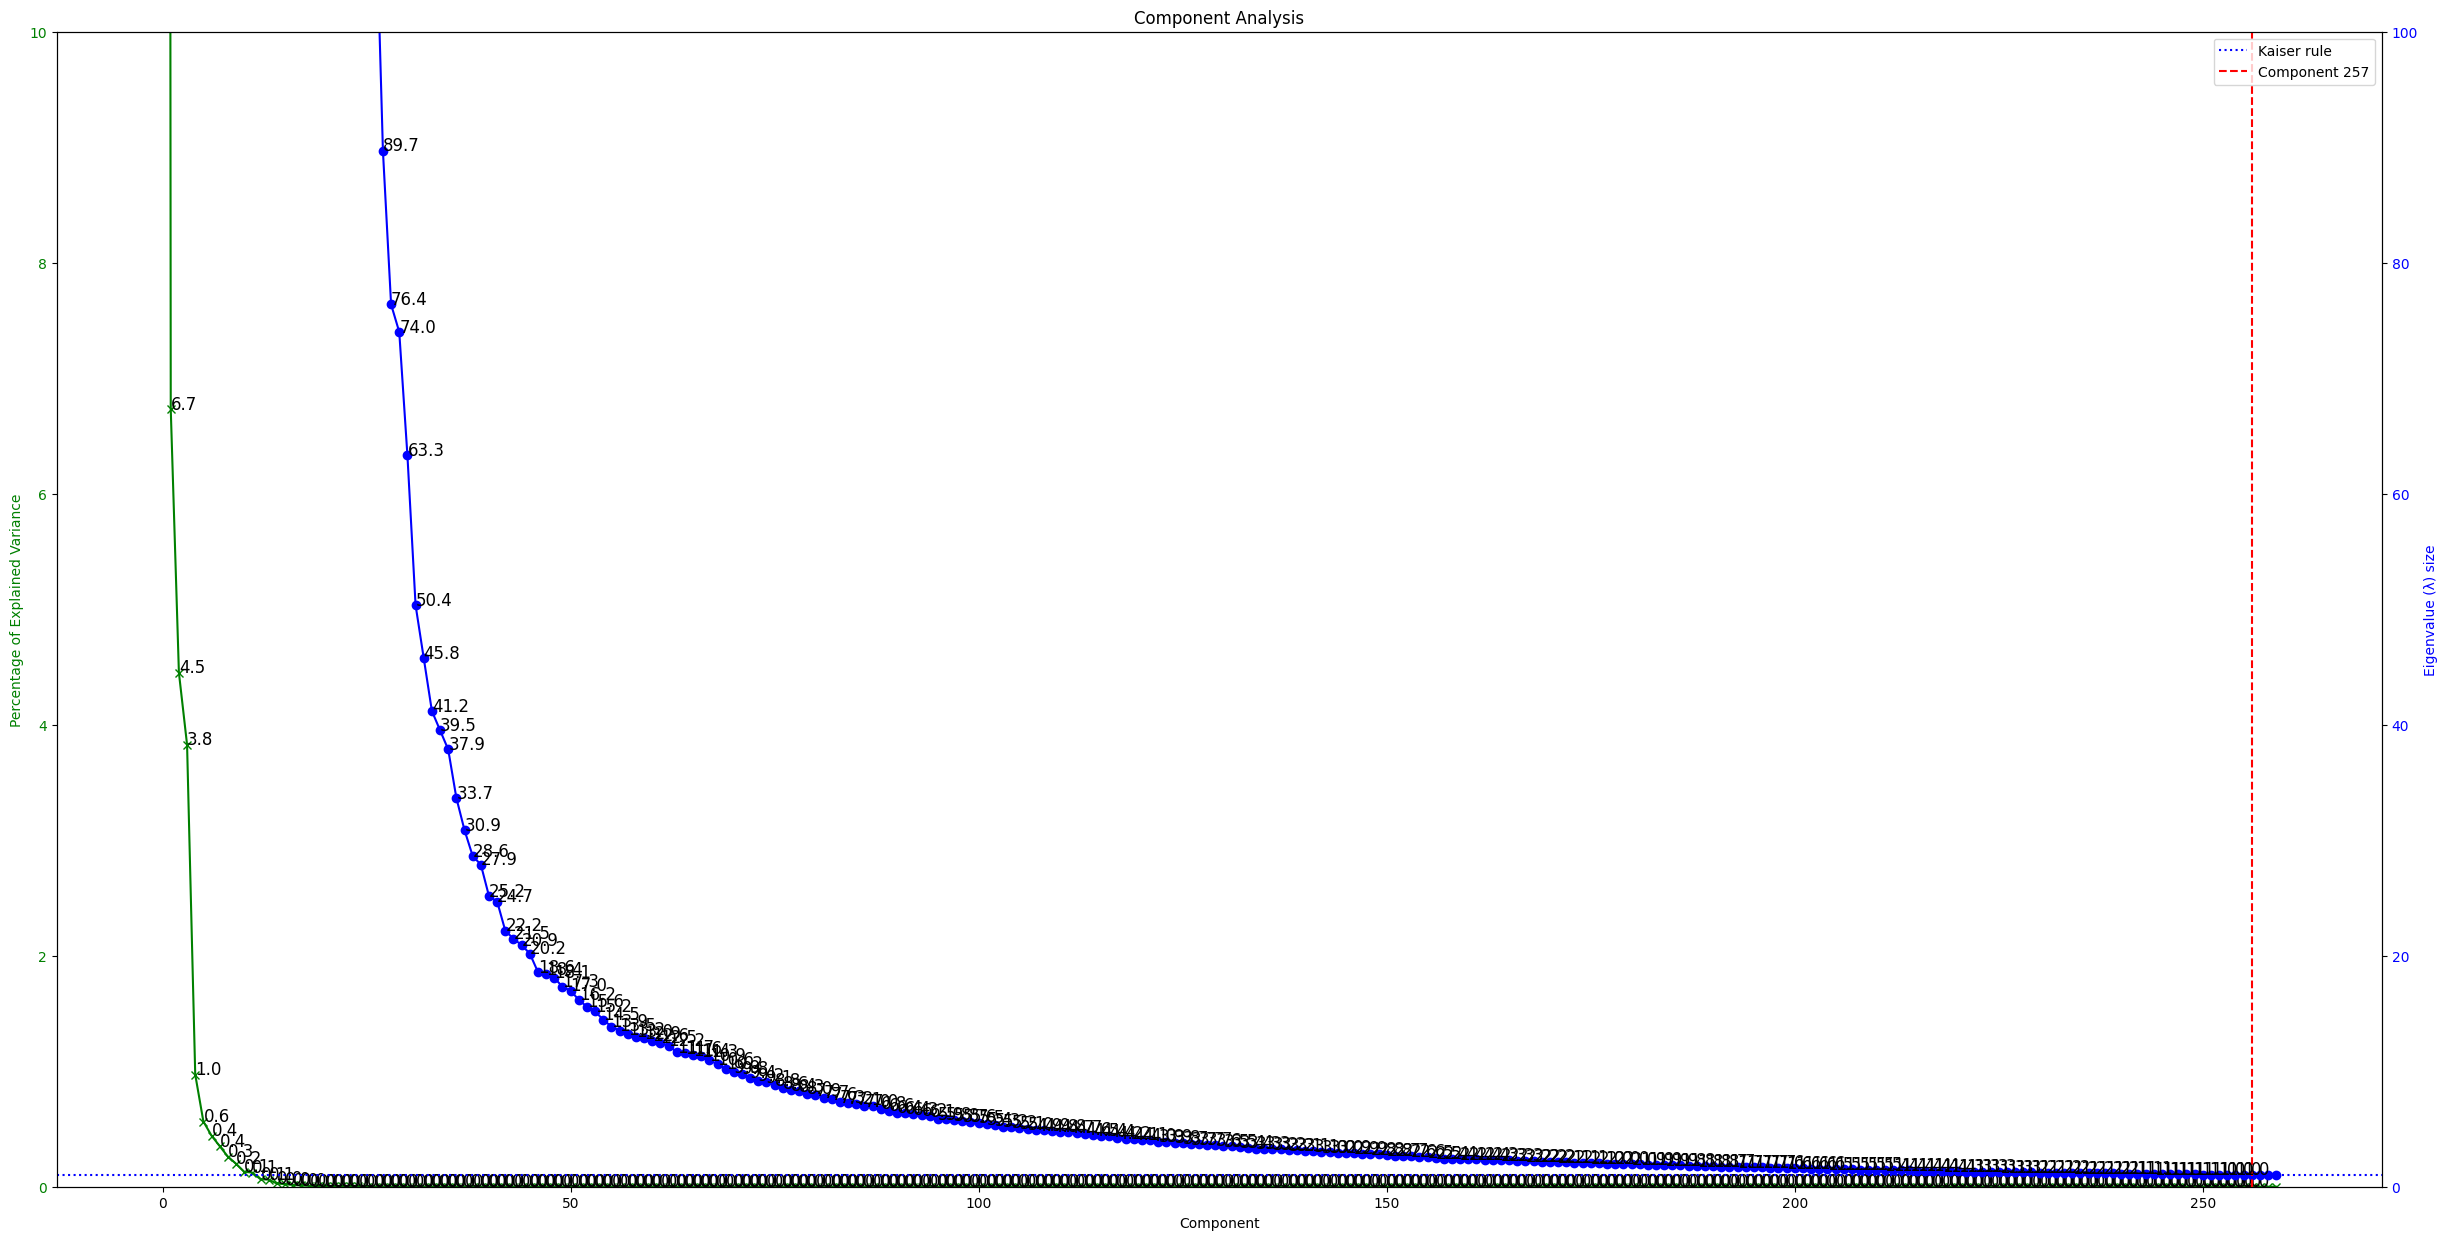

Amount of variance explained by 256 components s.t. λ_component > 1: 99.99999999999999%


In [22]:
# Linear PCA
pca = PCA(n_components=260, svd_solver="full")
pca_results = pca.fit_transform(images)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 10
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] - 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
linear_pca_results = linear_pca.fit_transform(images)

sum = 0
for index in range(num_components):
    if(len(intersection) > 0):
        sum = sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)
    
ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(sum) + "%")

Looking at the graph, we can see that our threshold (where *λ == 1*) was at component 257 for the linear PCA, meaning we will take a new linear PCA of 256 components. This is able to explain essentially all (>99.99%) of our varience, meaning we should hopefully see a pretty clear image after doing a reverse transformation.

This process can be thought of as being analogous to (rudimentary) image compression, where we are trying to remove as much data (pixels) from the image as possible while still retraining the maximum amount of information (detail). If this goes well, the linear PCA's components (or compressed image) will have significantly less dimensionality (<b>256 vs 110,592!</b>) while still retaining sufficent information for doing accurate classification with.

But before we get ahead of ourselves, let's take a look at what our newly reduced image looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


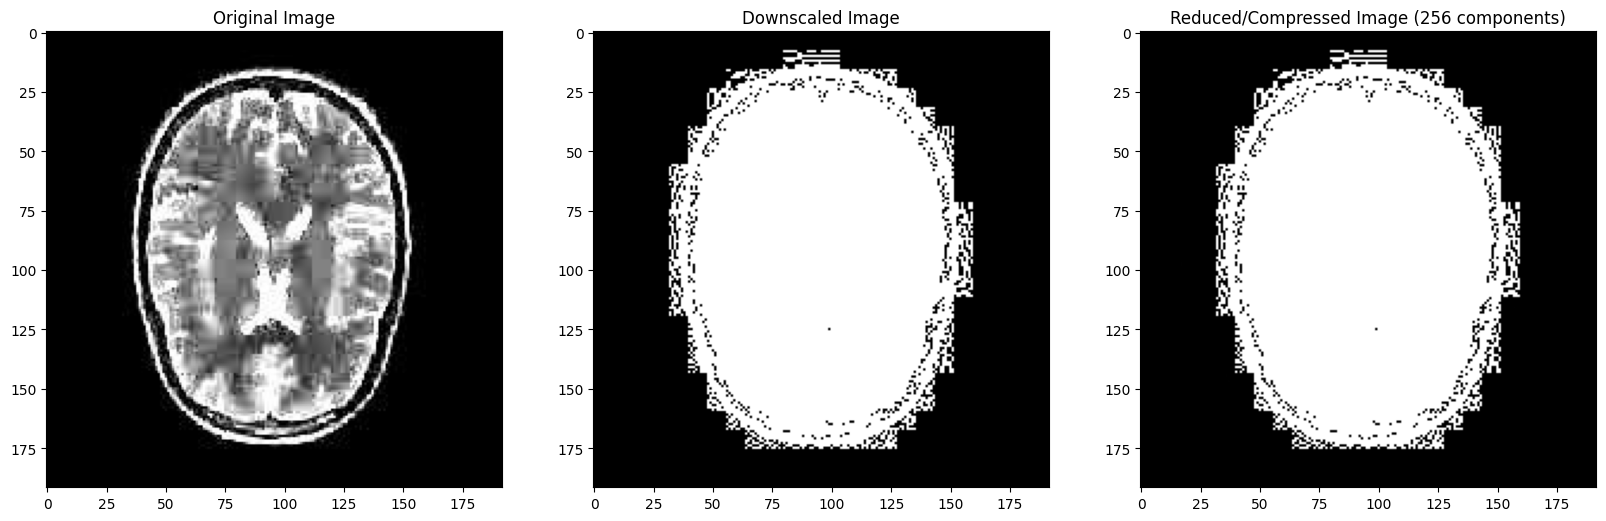

In [23]:
# Look at the randomly selected index 25 to see a different image for comparison
linear_imgs = linear_pca.inverse_transform(linear_pca_results)
lin_components = num_components

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(cancer_images[25], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[25].reshape(192, 192, 3), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(linear_imgs[25].reshape(192,192,3), 0, 1), cmap="gray")
ax[2].set_title("Reduced/Compressed Image (" + str(lin_components) + " components)")
plt.show()

We pick a new index as compared to the one used during data cleaning, to hopefully give us a better sense of what's happening to any given image, and also disassociate the data cleaning process with the data reduction process (which are both components of the wider umbrella of preprocessing).

As we can see from the image, we appear to retain a great deal of information compared to the downscaled image, which is what we were hoping for. We will need to take a more thorough look at the statistical difference between these images later, but we can at least verify that the PCA is performing as expected and is able to accurately compute a method for seperating the image into highly (at least visually) repersenatative components of the original image.

In fact, in some areas (such as around the small amounts of white on the left and right sides of the skulls), it appears we may even have slightly more definition/sharpness as compared to the compress image, which might help make features like brain tumors easier to discern - this remains merely speculation without further analysis, but it is interesting to see how the anti-alising and PCA have resulted in an image with much less artifacting (the boxes of pixels visable in the original image) than the original, despite being smaller and containing less data & information.

### 3.3 Randomized PCA
Next we can repeat the same process as before, except with a randomized PCA instead of a linear one. By comparison, with the randomized PCA we might expect worse results but a much shorter time to compute the transformation, although perhaps with this dataset it may prove to be more valuable than the linear PCA and its full SVD solver given the number of features. There's more nuance to the differences between the methods, but this will be saved for after the transformation is complete and we have results to elaborate against.

Again, we'll find our component threshold and then take a "final" PCA using that amount to get the transformation that we need to visualize the newly reduced images. One notworthy aspect present in the code is that the random_state parameter has been passed with a largely arbitrary argument of 110592 (the number of pixels in an image) so that the results in this notebook are verifiable: feel free to experiment with different values or remove the value entirely if you want to examine randomized PCA more fully on your own.

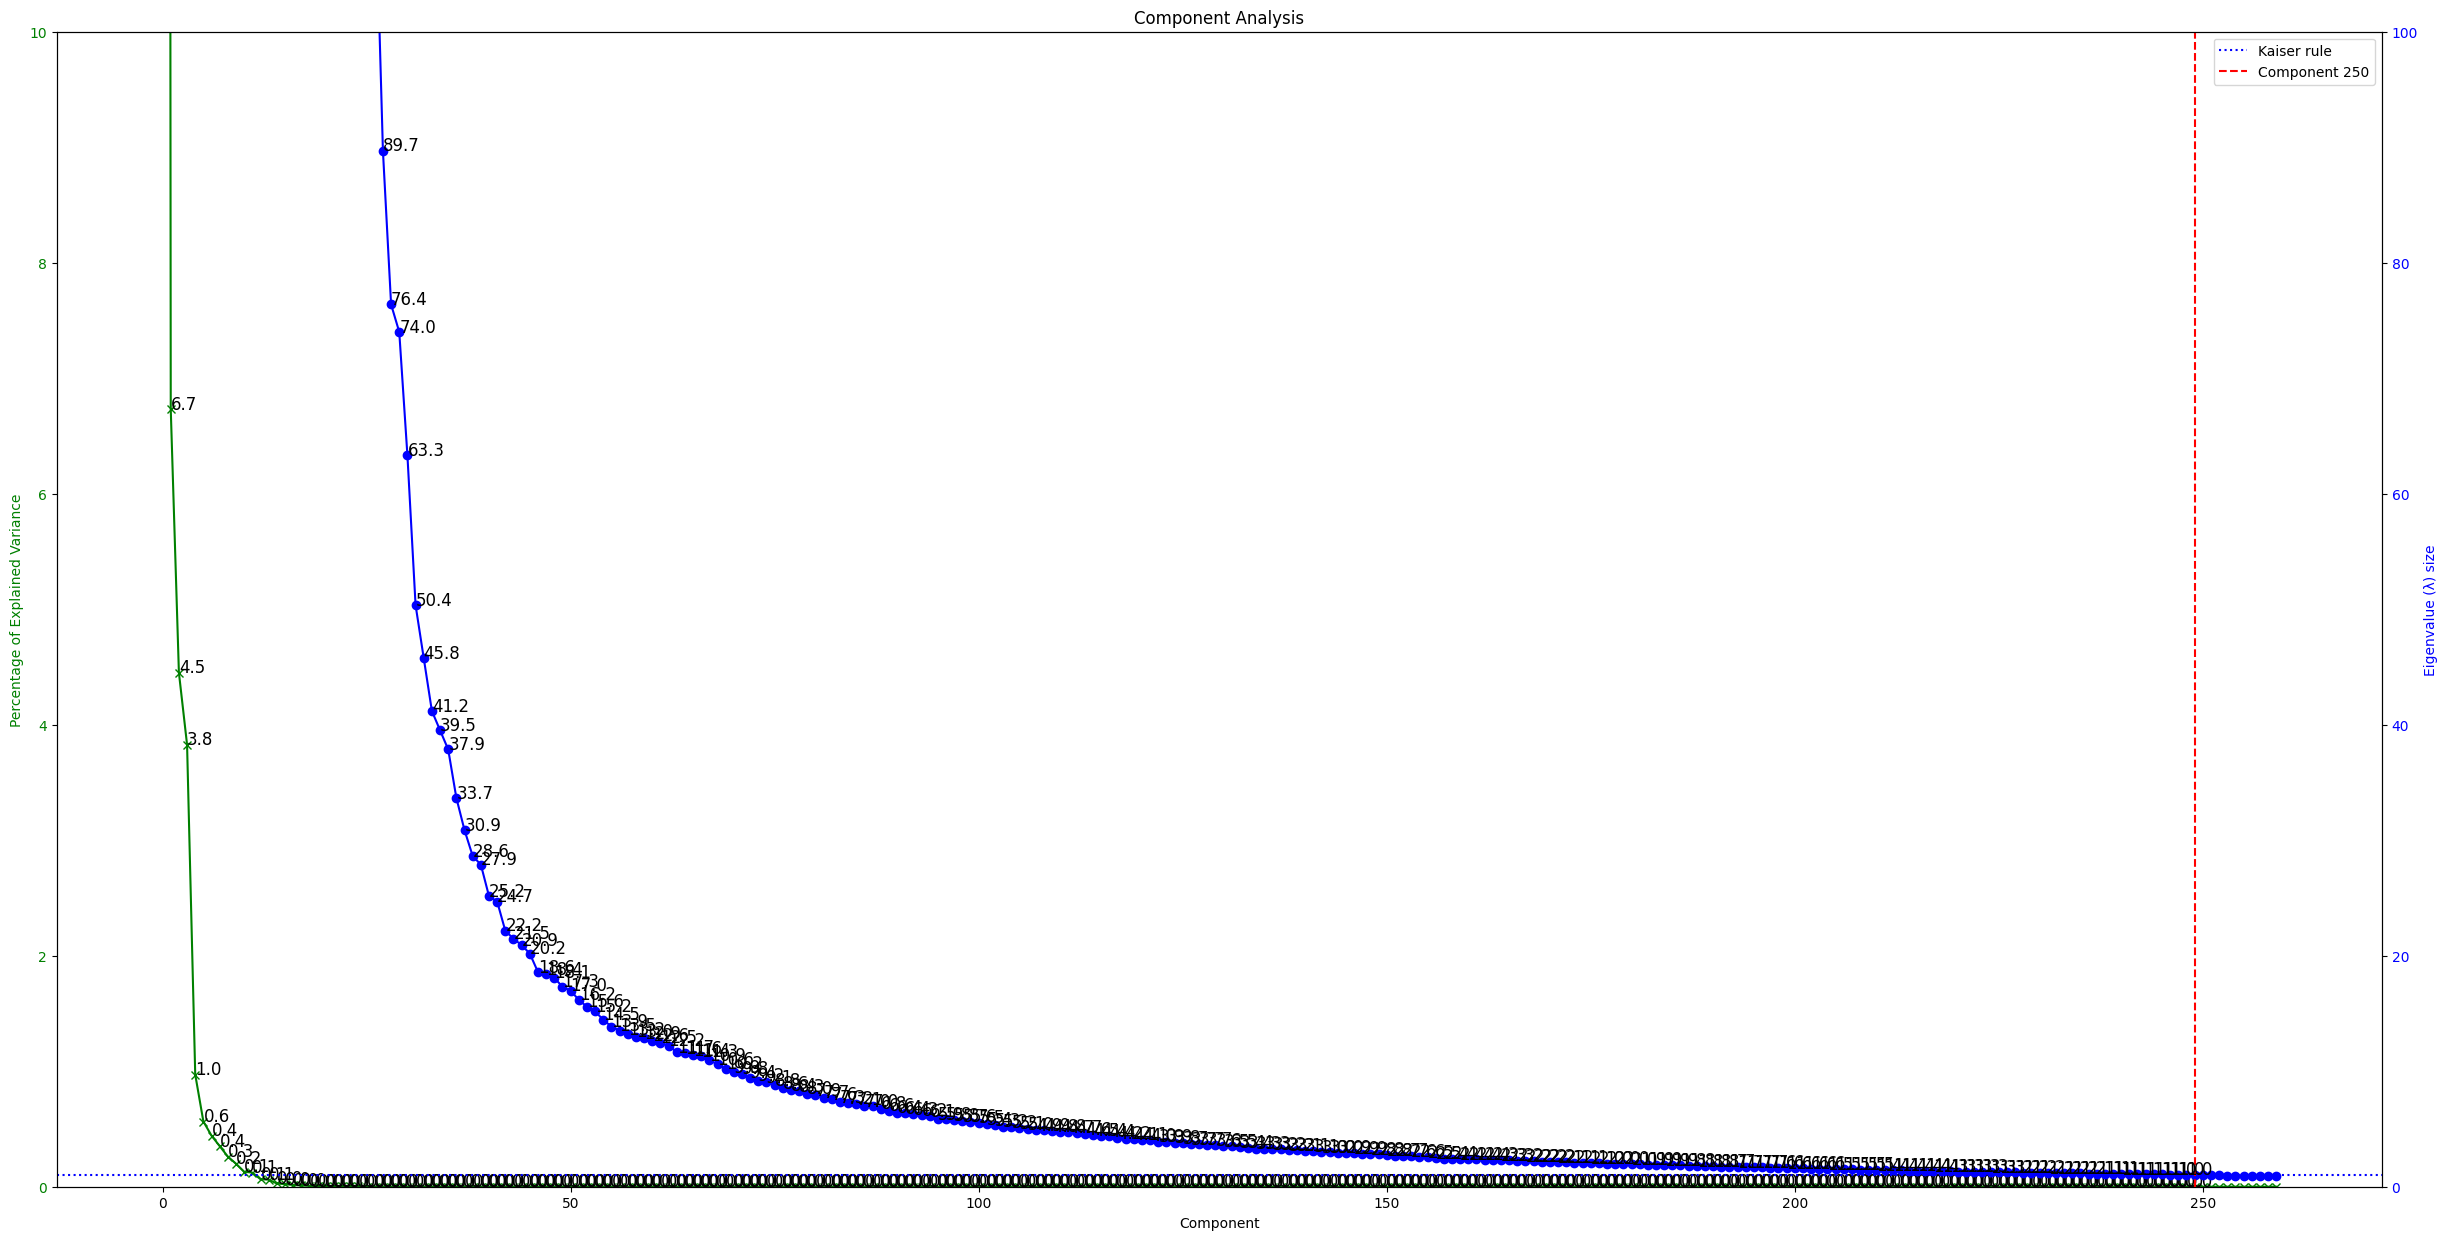

Amount of variance explained by 249 components s.t. λ_component > 1: 99.99999999999999%


In [24]:
# Randomized PCA
# Set random_state arbitrarily to pixel count to keep results repeatable
pca = PCA(n_components=260, svd_solver="randomized", random_state=110592)
pca_results = pca.fit_transform(images)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 10
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] - 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

randomized_pca = PCA(n_components=num_components, svd_solver="full")
randomized_pca_results = randomized_pca.fit_transform(images)

sum = 0
for index in range(num_components):
    if(len(intersection) > 0):
        sum = sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)
    
ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(sum) + "%")

Immediately we see our first visual/notable difference between the two methods: where the linear PCA fitting required 256 components to explain 99.99% of the image's varience, the randomized PCA only needed 249. This is not a huge difference (~2.7%) in components, but still noteworthy in the sense that you would not generally expect randomized methods to need fewer components to explain the same amount of varience. Otherwise, the graphs appear to follow the same general trend (which is good, as that means randomized PCA is finding similiar components as compared to linear PCA).

Since randomized PCA looks at the number of principal components instead of the number of features as its asympotoic bounding term, this process (although not timed) was significantly faster than the linear PCA. Given that this means it uses a random projection matrix instead of computing the eigenvectors of a covarience matrix in order to achieve this speedup, we generally expect worse performance. However, the randomized PCA appears to have a good job explaining the varience of the images, so we can proceed to visually displaying one of the iamges and checking to see if there's any noteworthy interactions happening between it and the downscaled & original images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


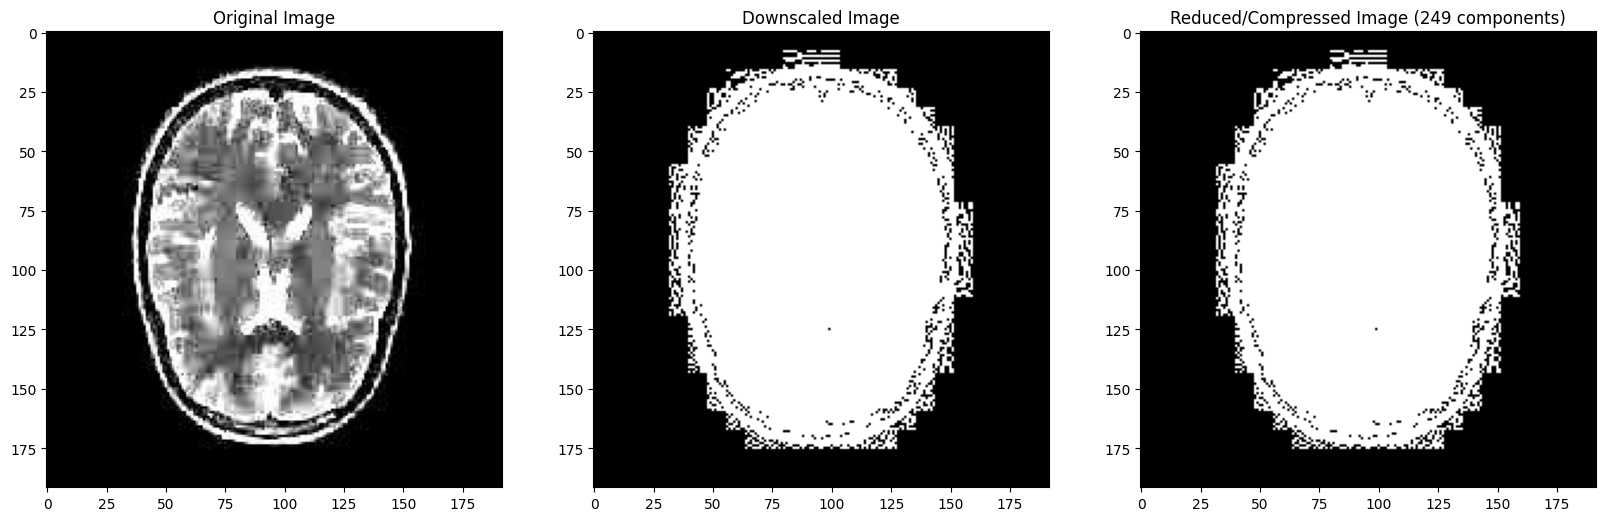

In [25]:
# Look at the randomly selected index 25 to see a different image for comparison
randomized_imgs = randomized_pca.inverse_transform(randomized_pca_results)
rand_components = num_components

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(cancer_images[25], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[25].reshape(192, 192, 3), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(randomized_imgs[25].reshape(192,192,3), 0, 1), cmap="gray")
ax[2].set_title("Reduced/Compressed Image (" + str(rand_components) + " components)")
plt.show()

Visually, at least, we appear to see the same performance that we saw with the linear PCA, which makes sense as the amount of varience explained by both was essentially the same. Again, the sharpness of the image appears to be higher as compared with the downscaled image, and the result overall appears to be promising: while the randomized PCA was very quick it was still able to create a image that - on first glance - looks similiar to the linear PCA result and certainly appears to capture the information contained within the downscaled image without inject too many artifacts or other corruptions of the image.

To determine which would be best suited to the task of classification, however, we will need to dive deeper and begin examining proper statistics to compute a quantifiable measurement of accuracy/error. However, randomized PCA is at least able to resolve the components of the image in a sensible manner which is already a step in the right direction. Onward, then, to the deep dive!

### 3.4 PCA Method Comparison


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


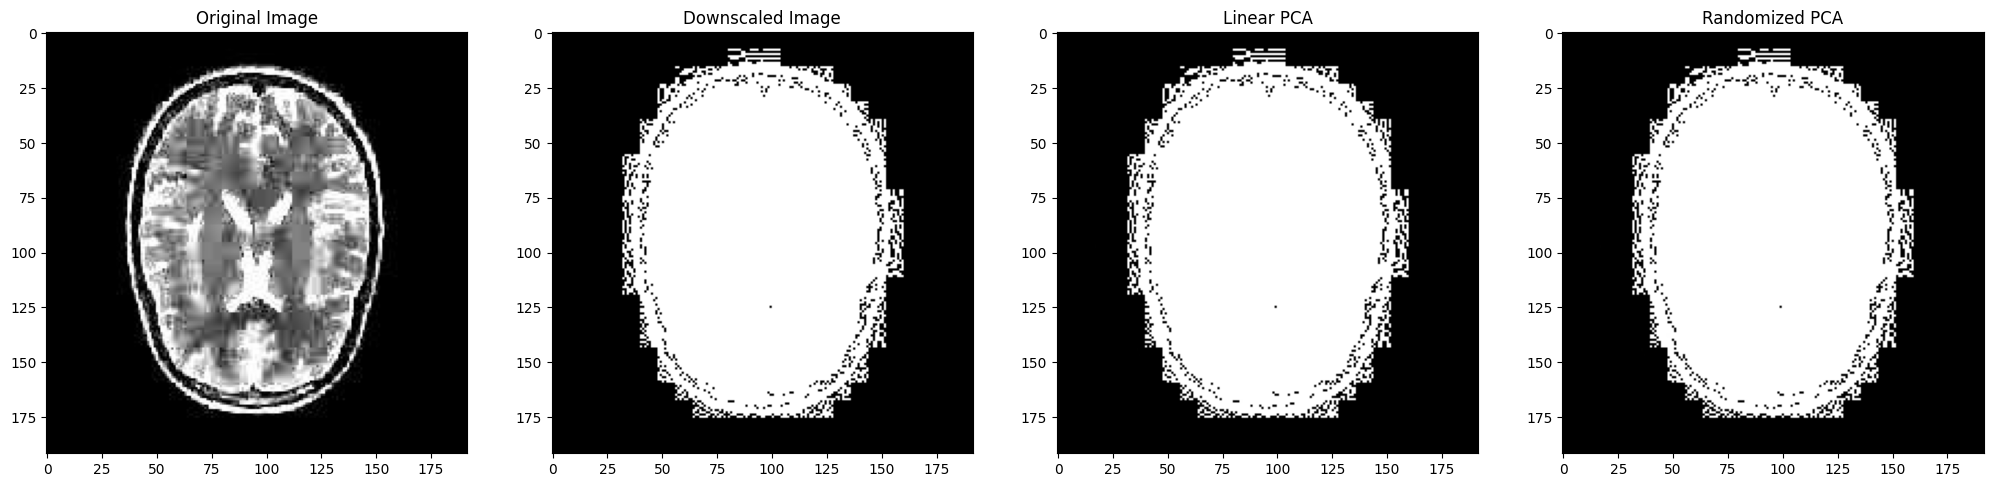

In [26]:
# Comparisons go here, interspace these sections with analysis

# TODO: convert this to have both PCA results + MSE visuals for each.
# A composite image might be nice as well? Experiment with it.
fig, ax = plt.subplots(1, 4, figsize=(25,10))
ax[0].imshow(cancer_images[25], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[25].reshape(192, 192, 3), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(linear_imgs[25].reshape(192,192,3), 0, 1), cmap="gray")
ax[2].set_title("Linear PCA")
ax[3].imshow(np.clip(randomized_imgs[25].reshape(192,192,3), 0, 1), cmap="gray")
ax[3].set_title("Randomized PCA")
plt.show()

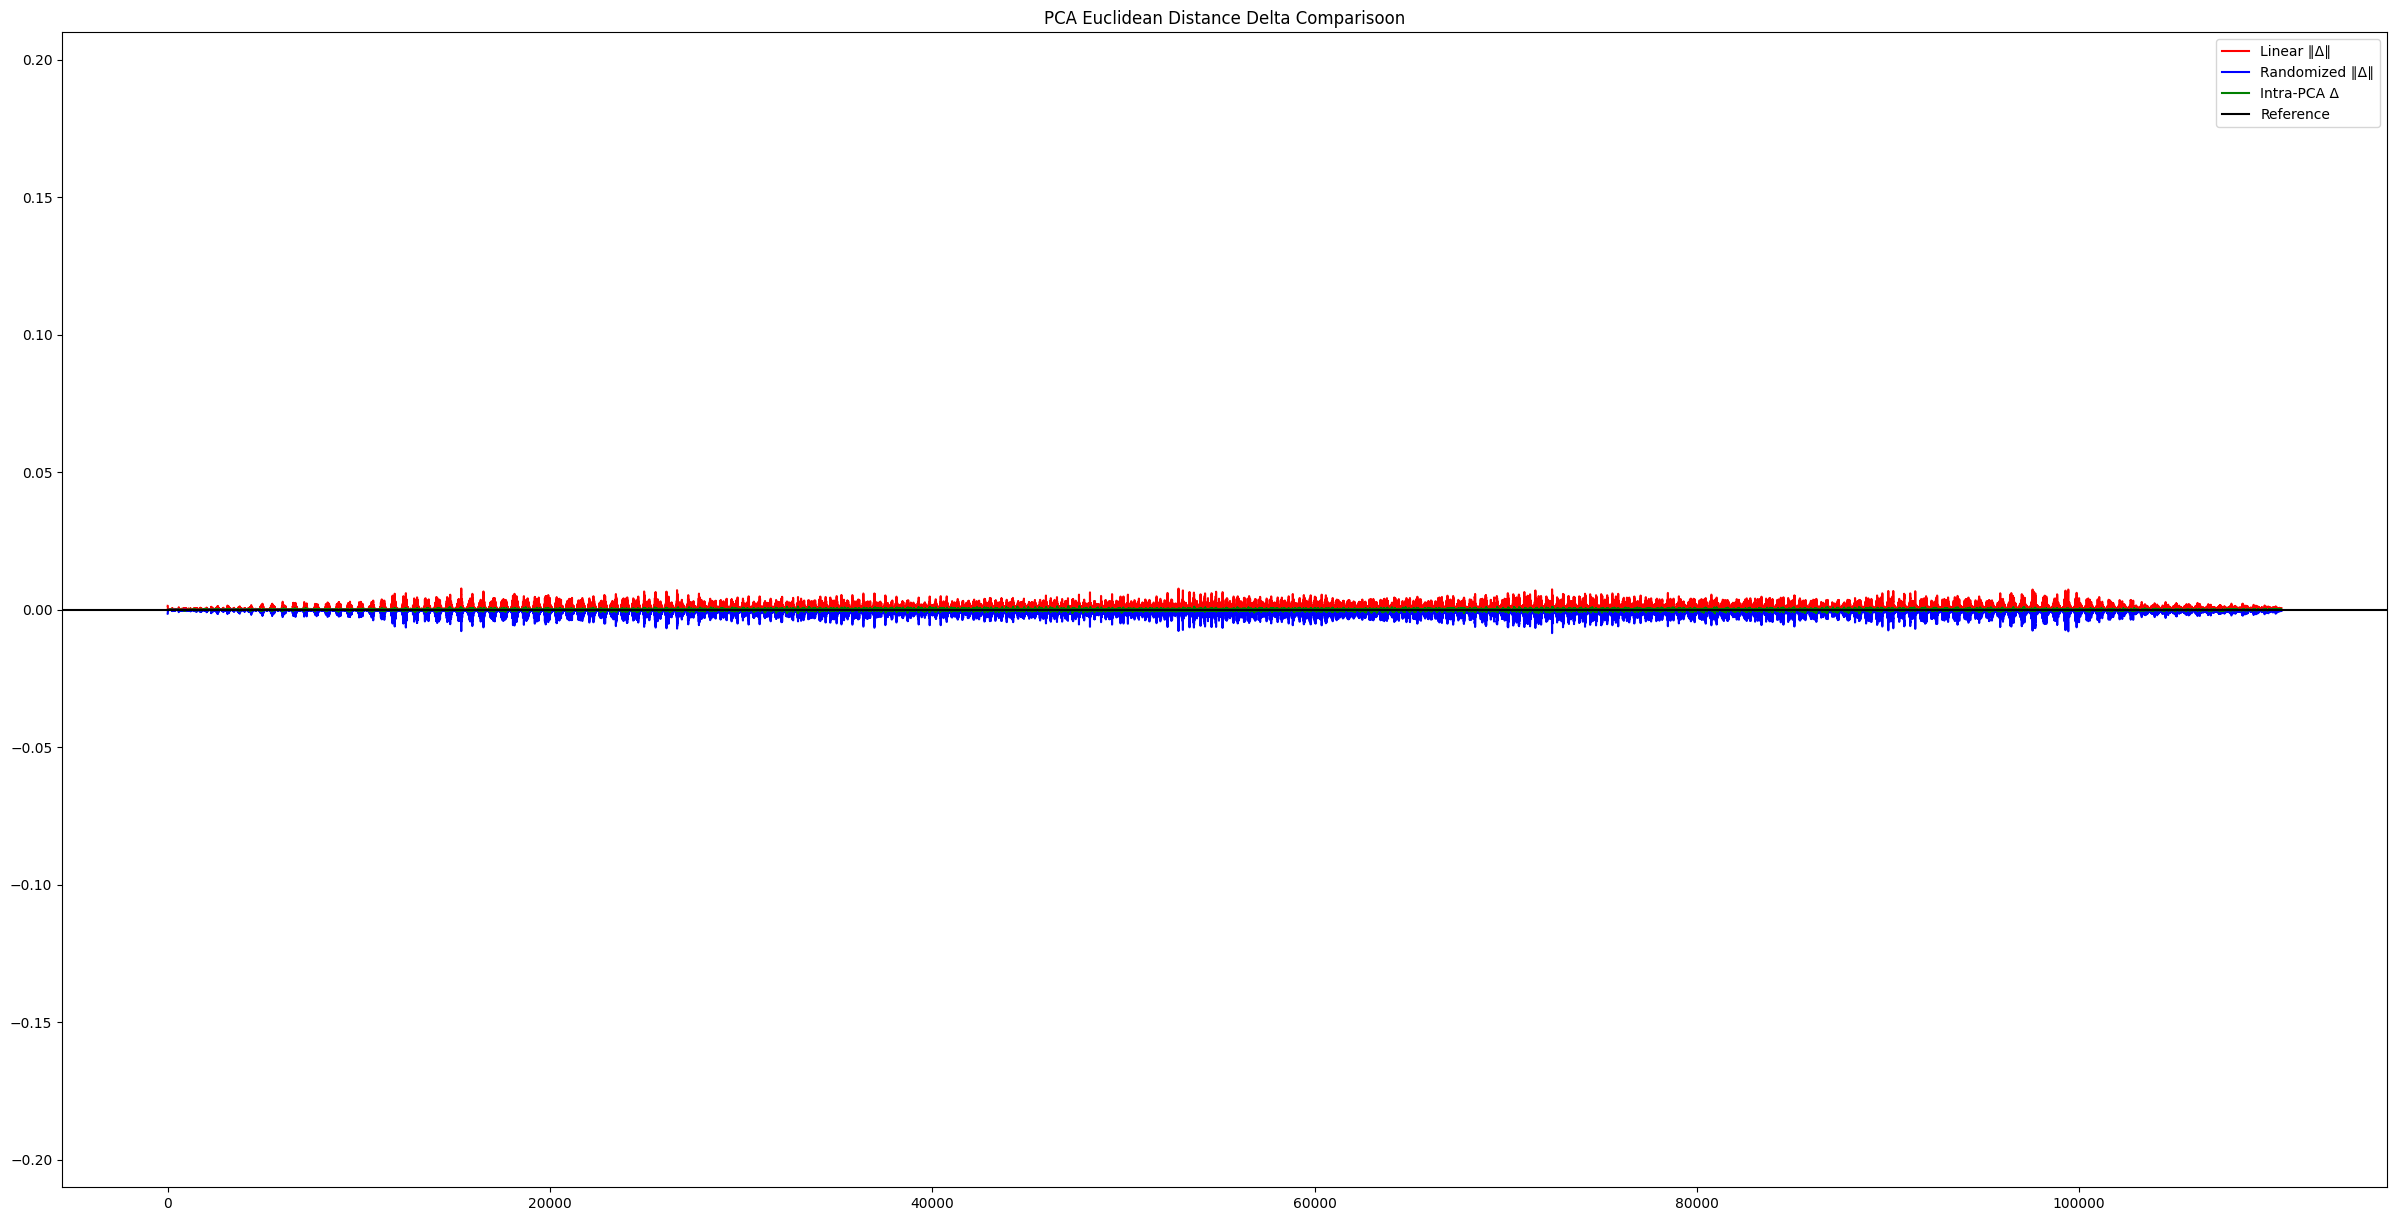

The linear PCA had a similarity of 99.92%
The randomized PCA had an similarity of 99.92%
-------------------------------------------------
The linear PCA was more accurate by 0.0%
And used 7 additional components by comparison.


In [27]:
plt.figure(figsize=(30, 15))
plt.title("PCA Euclidean Distance Delta Comparisoon")
plt.ylim(-0.21,0.21)
#plt.plot(x, images[25], color="blue", label="Baseline")
#plt.plot(x, linear_imgs[25], color="green", label="Linear")
#plt.plot(x, randomized_imgs[25], color="orange", label="Randomized")

plt.plot(np.abs(linear_imgs[25]-images[25]), color="red", linestyle="-", label="Linear ∥Δ∥")
plt.plot(-np.abs(randomized_imgs[25]-images[25]), color="blue", linestyle="-", label="Randomized ∥Δ∥")
plt.plot(randomized_imgs[25]-linear_imgs[25], color="green", linestyle="-", label="Intra-PCA Δ")
plt.axhline(y=0, color="black", linestyle="-", label="Reference")
plt.legend(loc="upper right")
plt.show()

lin_score, _ = ssim(linear_imgs[25], images[25], full=True)
rand_score, _ = ssim(randomized_imgs[25], images[25], full=True)
print("The linear PCA had a similarity of " + str(round(lin_score * 100, 2)) + "%")
print("The randomized PCA had an similarity of " + str(round(rand_score * 100, 2)) + "%")
print("-------------------------------------------------")
# Agony. Anguish. Despair.
print("The "
      + ("linear" if lin_score >= rand_score else "randomized")
      + " PCA was more accurate by "
      + str(round(max(lin_score - rand_score, rand_score - lin_score) * 100, 2))
      + "%\nAnd used "
      + str(lin_components - rand_components if lin_score >= rand_score else rand_components - lin_components)
      + (" additional" if lin_score >= rand_score and lin_components - rand_components >= 0 or rand_score >= lin_score and rand_components - lin_components >= 0 else " fewer")
      + " components by comparison.")

# Add a box & whisker plot to view the distribution of the amount of error for each

Lorem ipsum.

### 3.5 DAISY (?)

Let's apply DAISY to see the results of reducing the feature set. 

DAISY may prove better results than PCA or RPCA because DAISY preserves spatial information after processing, so we can assume that it'll be more promising for our image data. PCA and RPCA remove that spatial information and treat the image as if its just some numerical data without any other context around it. DAISY captures relevant angular information of an image and their magnitude, and is also able to calculate the number of angles within a certain area and what the distribution of each of those angles within that area.

Daisy comes with several hyperparamters that we can tune to our favourite flavor, 
It works choosing a central point in the image, and forming an initial ring around that central point and calculates histograms with a defined radius size around that ring. The rings paramter defines how many rings are created for histogram calculation and concatenation. DAISY allows you to define the number of "orientations" which are sectors of angular direction to which build into histogram calculation. Each orientation is a "bin" or "sector" or a set of angles and their respective magnitudes. 

In [122]:
from skimage.color import rgb2gray

def apply_daisy(row, shape, step, radius, rings, histograms, orientations):
        feat = daisy(row.reshape(shape), step=step, radius=radius, 
            rings=rings, histograms=histograms, orientations=orientations, 
            visualize=False)
        # return feat
        return feat.reshape(-1)

original_shape = (3*192, 192)
shape = original_shape

images_2 = images[:20, :] # WC - Only calculating based on a small sample of observations or my laptop will cry
# images_2 = images # uncomment this and remove above when we're ready to unleash the beast

daisy_feature_imgs = np.apply_along_axis(
    apply_daisy, 
    1, 
    images_2, 
    shape=shape,
    step=20,
    radius=20,
    rings=2,
    histograms=8,
    orientations=8)

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1]}")

print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1]}")

Original shape: (20, 110592)
Original number of features: 2211840
Post Daisy shape: (20, 29376)
Post-Daisy number of features: 587520


Let's see what happens when we increase the amount of rings and histograms, and how that affects the amount of features detected by DAISY. By increasing the radius, we are making the area of each of the circles to compute the histograms of gradients and orientations larger, and the amount of rings means that a higher frequency of histograms will be calculated. I believe this should increase the amount of features detected than previously.

In [123]:
daisy_feature_imgs = np.apply_along_axis(
    apply_daisy, 
    1, 
    images_2, 
    shape=shape,
    step=20,
    radius=20,
    rings=4,
    histograms=12,
    orientations=8)

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1]}")

print("====================")
print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1]}")

Original shape: (20, 110592)
Original number of features: 2211840
Post Daisy shape: (20, 84672)
Post-Daisy number of features: 1693440


As we expected, there are a larger amount of features detected than before. This tells us that the frequency of features detected per image increases as the number of histograms and radius size increase.


Let's now see what happens when we increase the step-count, and decrease the number of orientations. The step count represents the spacing between each of the circles along each radius to calculate histograms. If that number is larger, that means that there is a larger distance in between each circle and therefore potentially less area covered. Because the orientations represents the "bins" of angles being calculated, I believe that a lower amount of orientations and higher step count will lead to less granularity in our number of features detected; meaning that we should have less features detected. 

Let's see if this is true:

In [124]:
daisy_feature_imgs = np.apply_along_axis(
    apply_daisy, 
    1, 
    images_2, 
    shape=shape,
    step=60,
    radius=20,
    rings=2,
    histograms=2,
    orientations=2)

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1]}")

print("====================")
print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1]}")

Original shape: (20, 110592)
Original number of features: 2211840
Post Daisy shape: (20, 270)
Post-Daisy number of features: 5400


In [114]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
daisy_pairwise = pairwise_distances(daisy_feature_imgs)

(20, 20)


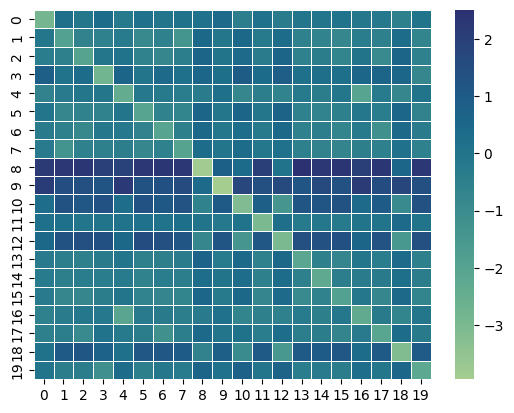

In [115]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_pairwise_daisy_imgs = scaler.fit_transform(X=daisy_pairwise, y=None)
print(scaled_pairwise_daisy_imgs.shape)
sns.heatmap(scaled_pairwise_daisy_imgs, linewidth=.5, cmap="crest")
plt.show()